In [12]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')
# A helper function for downloading files
import requests
import os
def download(url, local_filename=None):
    """
    Downloads the file in the ``url`` and saves it in the current working directory.
    """
    data = requests.get(url)
    if local_filename is None:
        local_filename = os.path.basename(url)
    with open(local_filename, 'wb') as fd:
        fd.write(data.content)

# Hands-on Activity 15.3: Diagnostics for posterior predictive

## Objectives

+ To introduce measures that quantify how good the posterior predictive distribution is.

## Example (Quadratic)

We start with our quadratic synthetic example because we know that our model is adequate.
You will see how the standarized errors will turn out perfect.

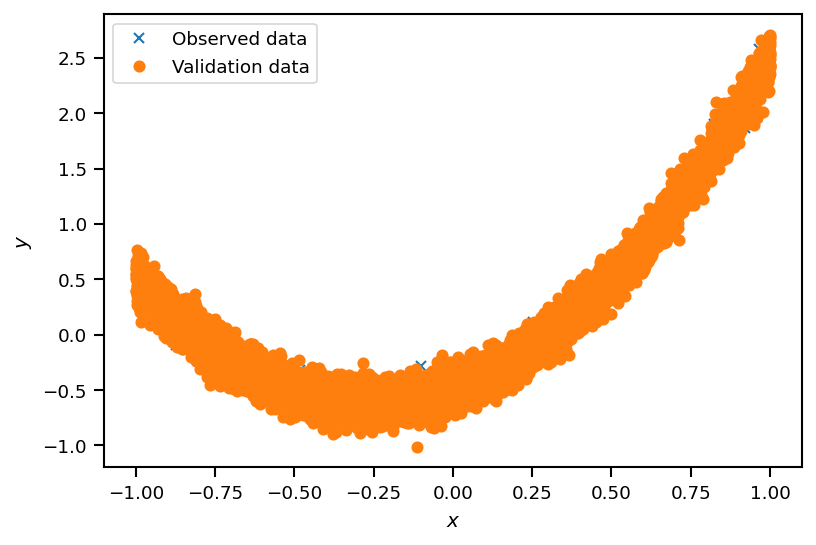

In [63]:
# The training data:
num_obs = 200
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 1.0
w2_true = 2.0
sigma_true = 0.1
y = w0_true + w1_true * x + w2_true * x ** 2 + sigma_true * np.random.randn(num_obs)

# Make some validation data
num_valid = 10000
x_valid = -1.0 + 2 * np.random.rand(num_valid)
y_valid = w0_true + w1_true * x_valid + w2_true * x_valid ** 2 + sigma_true * np.random.randn(num_valid)

# Let's plot the data
fig, ax = plt.subplots(dpi=150)
ax.plot(x, y, 'x', label='Observed data')
ax.plot(x_valid, y_valid, 'o', label='Validation data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best');

Let's also copy-paste the code for creating design matrices for the three generalized linear models we have considered so far:

In [64]:
def get_polynomial_design_matrix(x, degree):
    """
    Returns the polynomial design matrix of ``degree`` evaluated at ``x``.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Let's fit the model using automatic relevance determination:

In [81]:
# Load the Bayesian linear regression class:
from sklearn.linear_model import ARDRegression
# Select polynomial degree and get design matrix
degree = 8
# Build the design matrix
Phi = get_polynomial_design_matrix(x[:, None], degree)
# Do not normalize. ARDRegression seems to have a bug when you do.
model = ARDRegression(normalize=False, fit_intercept=False).fit(Phi, y)

/Users/isaacbowser/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Let's visualize the resulting model:

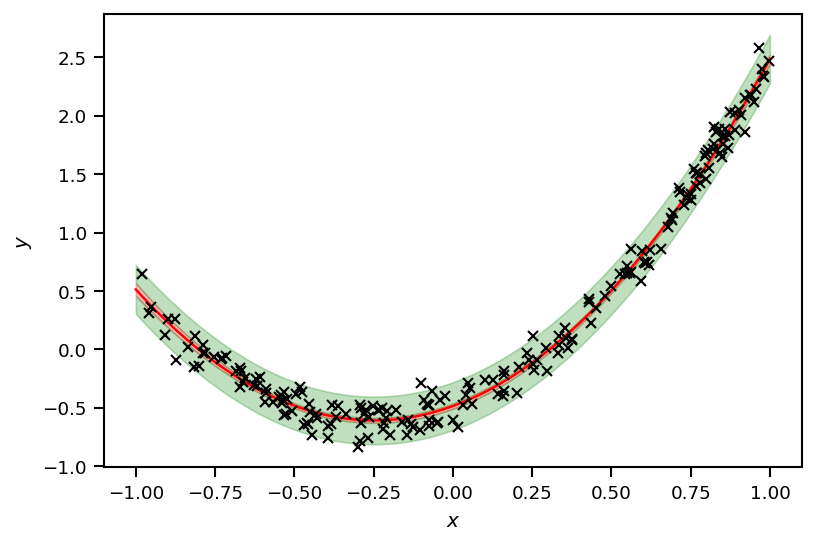

In [82]:
sigma = np.sqrt(1.0 / model.alpha_)
xx = np.linspace(-1, 1, 100)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
yy_mean, yy_measured_std = model.predict(Phi_xx, return_std=True)
yy_std = np.sqrt(yy_measured_std ** 2 - sigma**2)
fig, ax = plt.subplots(dpi=150)
ax.plot(xx, yy_mean, 'r')
# Epistemic lower bound
yy_le = yy_mean - 2.0 * yy_std
# Epistemic upper bound
yy_ue = yy_mean + 2.0 * yy_std
# Epistemic + aleatory lower bound
yy_lae = yy_mean - 2.0 * yy_measured_std
# Episemic + aleatory upper bound
yy_uae = yy_mean + 2.0 * yy_measured_std
ax.fill_between(xx, yy_le, yy_ue, color='red', alpha=0.25)
ax.fill_between(xx, yy_lae, yy_le, color='green', alpha=0.25)
ax.fill_between(xx, yy_ue, yy_uae, color='green', alpha=0.25)
# plot the data again
ax.plot(x, y, 'kx', label='Observed data')
# The true connection between x and y
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
# overlay the true 
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

And now let's make predictions on the validation data:

In [83]:
Phi_valid = get_polynomial_design_matrix(x_valid[:, None], degree)
y_predict, y_std = model.predict(Phi_valid, return_std=True)

First, let's do the observations vs predictions plot:

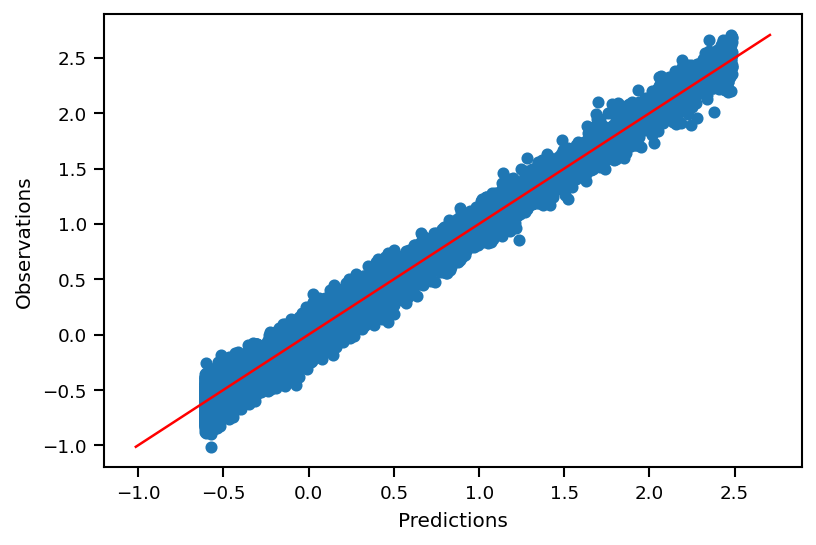

In [84]:
fig, ax = plt.subplots(dpi=150)
ax.plot(y_predict, y_valid, 'o')
yys = np.linspace(y_valid.min(), y_valid.max(), 100)
ax.plot(yys, yys, 'r-');
ax.set_xlabel('Predictions')
ax.set_ylabel('Observations');

It's okay. However, notice that the predictions do not fall on the red line because there is a little bit of noise on the observations.

Let's now compute the standarized errors:

In [85]:
eps = (y_valid - y_predict) / y_std

Remember, that if the model is correct, the standarized errors must follow a standard normal.
There are various ways to check this.
First, let's just plot them:

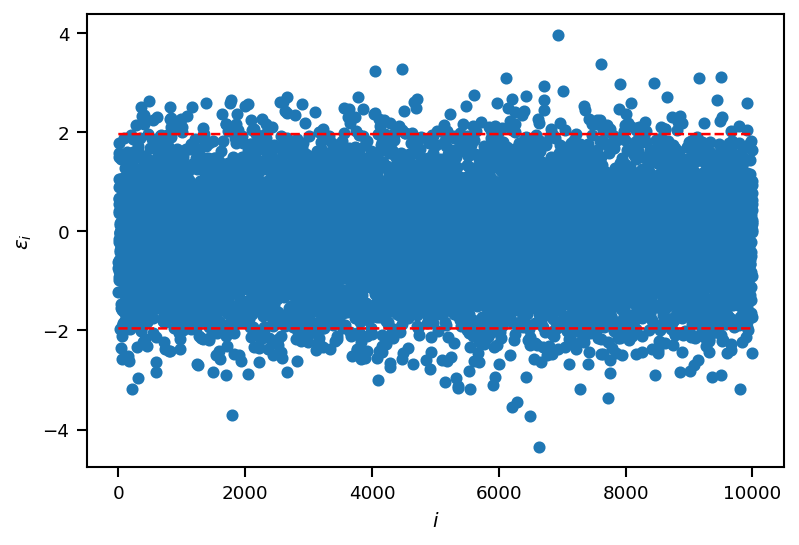

In [86]:
fig, ax = plt.subplots(dpi=150)
idx = np.arange(1, eps.shape[0] + 1)
# The standarized errors
ax.plot(idx, eps, 'o', label='Standarized errors')
# The 97.5% quantile of the normal as a red dashed line
ax.plot(idx, 1.96 * np.ones(eps.shape[0]), 'r--')
# The 2.5% quantile of the normal as a red dashed line
ax.plot(idx, -1.96 * np.ones(eps.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$\epsilon_i$');

Notice that the majority of the standarized errors fall within the 95% central credible interval for $N(0,1)$.
This is an indication that the model is good.

The other plot we can do is the histogram of the standarized errors compared to the probability density of the standard normal:

What if you wanted to get the samples from the posterior?
You would have to do a little bit of manual work to translate the posterior weights and their variance back to the original values...

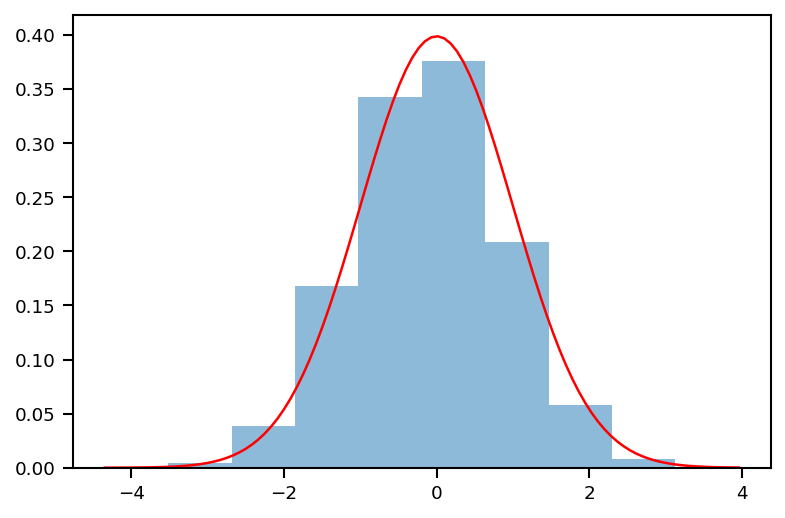

In [87]:
import scipy.stats as st

fig, ax = plt.subplots(dpi=150)
ax.hist(eps, alpha=0.5, density=True)
ee = np.linspace(eps.min(), eps.max(), 100)
ax.plot(ee, st.norm.pdf(ee), 'r');

Not perfect, but a pretty good fit.

The final diagnostic is the so call quantile-quantile plot.
This compares the empirical quantiles of the standarized errors (computed by building and inverting the empirical cummulative distribution function, see Lecture 9).
Here is how to do it:

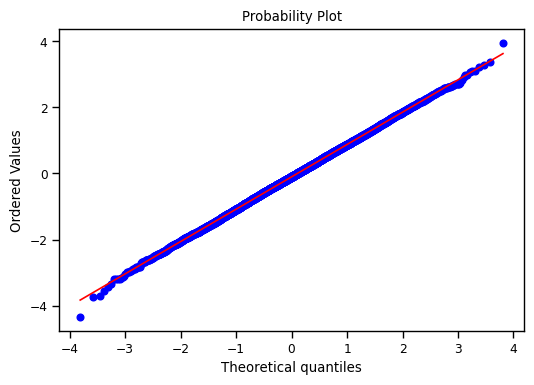

In [88]:
fig, ax = plt.subplots(dpi=100)
st.probplot(eps, dist=st.norm, plot=ax);

This is also indicative of a pretty good fit.

### Questions

+ Rerun the code blocks above with a large number of training observations, say 100. Did the diagnosics improve or are they the same?
+ Keep the number of training observations to 100 and change the validation points to 1000. How do the diagnostics look like now?
+ Let's now try a model that is not adequate for the data. Set the polynomial degree to 1 and rerun everything. How do the diagnostics look like now?